In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from math import factorial
import random

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

In [5]:
def powerset(n):
    subsets = []
    for i in range(1 << n):
        subset = [j for j in range(n) if (i & (1 << j))]
        subsets.append(subset)
    return subsets

def shapley_values(X, y):
    if hasattr(X, "columns"):
        feature_names = X.columns.to_list() 
        X = X.to_numpy()
    else:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]
    
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()
    
    n_features = X.shape[1]
    phi = np.zeros(n_features)
    subsets = powerset(n_features)

    for i in range(n_features):
        shapley_sum = 0

        for S in subsets:
            if i in S:
                continue  

            S_set = set(S)
            S_size = len(S_set)
            coeff = factorial(S_size) * factorial(n_features - S_size - 1) / factorial(n_features)

            X_S = X[:, S] if S else np.ones((X.shape[0], 1))  
            X_Si = X[:, list(S_set | {i})]  

            model_s = LinearRegression().fit(X_S, y)
            f_s = model_s.predict(X_S).mean()

            model_si = LinearRegression().fit(X_Si, y)
            f_si = model_si.predict(X_Si).mean()

            shapley_sum += coeff * (f_si - f_s)

        phi[i] = shapley_sum
    
    sorted_indices = np.argsort(phi)[::-1]
    
    print("Вклад признаков:")
    for idx in sorted_indices:
        print(f"{feature_names[idx]}: значение Шепли = {phi[idx]}")

shapley_values(train_cut_X, train_y)

Вклад признаков:
compression: значение Шепли = 0.0
consumption-mixed: значение Шепли = -1.1368683772161603e-13
charge-time: значение Шепли = -1.1368683772161603e-13
battery-capacity: значение Шепли = -1.1368683772161603e-13
back-suspension: значение Шепли = -1.1368683772161603e-13


In [6]:
model = LinearRegression()
model.fit(train_cut_X, train_y)

y_pred_initial = model.predict(test_cut_X)
initial_mse = mean_squared_error(test_y, y_pred_initial)

def permutation_importance(model, X, y, metric=mean_squared_error, n_repeats=10):
    importances = []
    
    for col in X.columns:
        score_list = []
        
        #повторим процесс несколько раз для устойчивости
        for _ in range(n_repeats):
            X_permuted = X.copy() #именно copy, при присваивании мы просто копируем ссылку на объект
            permuted_values = X[col].values.tolist()
            random.shuffle(permuted_values) #перемешаем через shuffle
            X_permuted[col] = permuted_values
            
            y_pred_permuted = model.predict(X_permuted)
            score = metric(y, y_pred_permuted)
            score_list.append(score)
        
        importances.append(np.median(score_list) - initial_mse) #используем медиану, так как она более устойчивая к выбросам
    
    return importances

importance_scores = np.array(permutation_importance(model, test_cut_X, test_y))
sorted_importance = sorted(zip(test_cut_X.columns, importance_scores), key=lambda x: x[1], reverse=True)

for col, score in sorted_importance:
    print(f"Признак {col}: {score:.4f}")

Признак back-suspension: 1873.4549
Признак consumption-mixed: 993.5827
Признак charge-time: 696.1804
Признак battery-capacity: 120.1824
Признак compression: 0.3762


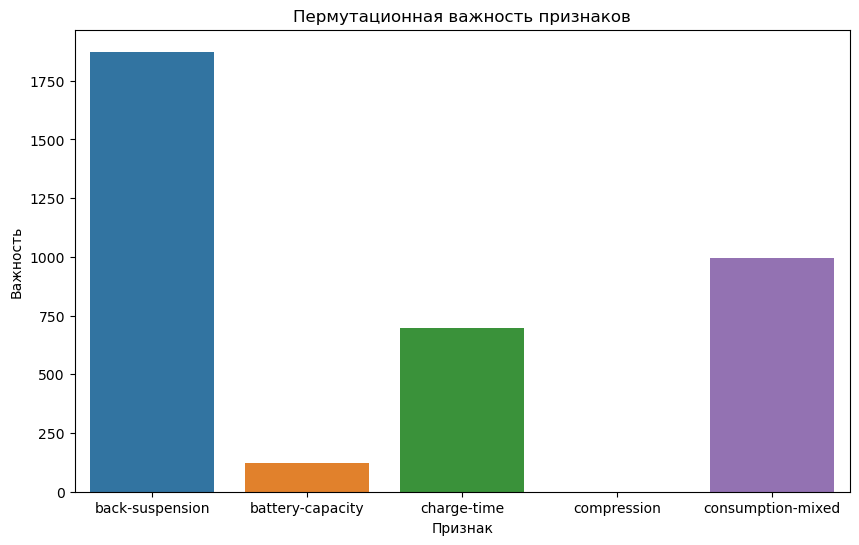

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x=test_cut_X.columns, y=importance_scores)
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.title('Пермутационная важность признаков')
plt.show()